fig1E: comparison between fetal and adult by gestation - ?Milo ? UMAP

# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import plotnine as pln
from plotnine import ggplot, aes
import seaborn as sn
import anndata
import scanpy as sc
import sctk as sk
# import scvelo as scv
# import cellrank as cr
from sklearn.preprocessing import minmax_scale

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

# Load data

## fetal skin

In [2]:
fetal_ad0 = sc.read('../gdrive/fetal_skin.norm.maternal_removed.20210611.h5ad')

Only considering the two last: ['.20210611', '.h5ad'].
Only considering the two last: ['.20210611', '.h5ad'].


In [3]:
fetal_ad0.shape

(186582, 28885)

what metadata is available in fetal skin?

In [4]:
fetal_ad0.obs.columns

Index(['sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample',
       'chemistry_sorting', 'cell_caller', 'scrublet_score',
       'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts',
       'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb',
       'independent_annotation_refined', 'independent_annotation_broad1',
       'independent_annotation_broad2', 'independent_annotation_broad3',
       'independent_annotation_broad4', 'independent_annotation_broad5',
       'joint_annotation', 'is_maternal', 'fig1b_annotation'],
      dtype='object')

What's in "pcw"?

In [5]:
fetal_ad0.obs.pcw.value_counts(dropna=False).sort_index()

7     34567
8     13641
9     15350
10     5231
11    18465
12    13435
13     7211
14    25951
15    46660
16     6071
Name: pcw, dtype: int64

what's in "independent_annotation_broad5"?

In [6]:
fetal_ad0.obs.independent_annotation_broad5.value_counts(dropna=False).sort_index()

Epithelium      2263
Erythroid       3468
Immune         59068
Stroma        121783
Name: independent_annotation_broad5, dtype: int64

what's in "fib1b_annotation"

In [7]:
fetal_ad0.obs.fig1b_annotation.cat.categories

Index(['Adipocyte', 'B cell', 'Dermal condensate', 'Erythroid', 'Fibroblast',
       'ILC', 'Keratinocyte', 'Langerhans cell', 'Lymphatic endothelium',
       'Macrophage', 'Mast cell', 'Megakaryocyte', 'Melanocyte', 'Microglia',
       'Monocyte', 'Myofibroblast', 'Neuronal cells', 'Neutrophil', 'Pericyte',
       'Progenitor', 'Schwann cell', 'Skeletal muscle', 'Smooth muscle',
       'T cell', 'Vascular endothelium', 'cDC', 'pDC'],
      dtype='object')

what's in "joint_annotation"

In [8]:
fetal_ad0.obs.loc[fetal_ad0.obs.independent_annotation_broad5=='Epithelium', 'joint_annotation'].value_counts().where(lambda x: x>0).dropna()

Basal                  815.0
Melanocyte             604.0
Basal SHH+             254.0
Melanoblast            190.0
Periderm               153.0
Immature basal          65.0
Basal POSTN+            46.0
Suprabasal IFE          30.0
Companion layer         27.0
Outer root sheath       25.0
Cuticle/cortex          21.0
Inner root sheath       18.0
Immature suprabasal     15.0
Name: joint_annotation, dtype: float64

what type of data is in "X"?

In [9]:
fetal_ad0.X.data

array([1.8038048, 1.4774609, 1.4774609, ..., 1.6299081, 2.2199435, 2.8572528], dtype=float32)

In [10]:
np.expm1(fetal_ad0.X[0:5,]).sum(axis=1)

matrix([[10005.071],
        [10006.827],
        [10006.456],
        [10006.766],
        [10001.346]], dtype=float32)

ok, seems it's log1p-transformed normalised values, let's restore to counts

In [11]:
fetal_ad0 = sk.restore_adata(fetal_ad0, restore_type='count', use_raw=False, use_n_counts='n_counts', force=True, rounding=True)

In [12]:
fetal_ad0.X.data

array([3., 2., 2., ..., 1., 2., 4.], dtype=float32)

## adult skin

In [13]:
adult_ad0 = sc.read('../gdrive/Healthy_all_data.h5ad')

In [14]:
adult_ad0.shape

(217266, 33538)

what metadata is available in adult skin?

In [15]:
adult_ad0.obs.columns

Index(['sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue',
       'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage',
       'anno_final', 'final'],
      dtype='object')

what's in "Age"?

In [16]:
adult_ad0.obs.Age.value_counts(dropna=False)

NaN    217266
Name: Age, dtype: int64

ok, basically no age information, set them to pcw 999 (40 + 18 * 52 = 976)

In [17]:
adult_ad0.obs['pcw'] = 999

there were some nan in cell type annotation in adult skin?

In [18]:
adult_ad0.obs.anno_final.value_counts(dropna=False).index.sort_values()

CategoricalIndex(['C_Melanocyte', 'DC1', 'DC2', 'F1', 'F2', 'F3', 'ILC1',
                  'ILC1_NK', 'ILC2_3', 'Inf_mono', 'LC_1', 'LC_2', 'LC_3',
                  'LC_4', 'LE1', 'LE2', 'M_A_Mast_cell', 'Macro_1', 'Macro_2',
                  'MigDC', 'Mono', 'NK', 'Pericyte_1_non_inflamm',
                  'Pericyte_2_inflamm', 'Plasma',
                  'Schwaan_1_Stroma_Schwan_myelinating',
                  'Schwaan_2_non_myelinating', 'Tc', 'Th', 'Treg', 'VE1',
                  'VE2', 'VE3', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
                  'moDC_1', 'moDC_2', 'moDC_3', 'nan'],
                 categories=['C_Melanocyte', 'DC1', 'DC2', 'F1', 'F2', 'F3', 'ILC1', 'ILC1_NK', ...], ordered=False, dtype='category')

there's indeed nan, let's remove them

In [19]:
adult_ad0 = adult_ad0[adult_ad0.obs.anno_final.astype(str) != 'nan'].copy()

make some broad annotations similar to that of fig1b_annotation in fetal skin

In [20]:
fetal_ad0.obs.fig1b_annotation.cat.categories

Index(['Adipocyte', 'B cell', 'Dermal condensate', 'Erythroid', 'Fibroblast',
       'ILC', 'Keratinocyte', 'Langerhans cell', 'Lymphatic endothelium',
       'Macrophage', 'Mast cell', 'Megakaryocyte', 'Melanocyte', 'Microglia',
       'Monocyte', 'Myofibroblast', 'Neuronal cells', 'Neutrophil', 'Pericyte',
       'Progenitor', 'Schwann cell', 'Skeletal muscle', 'Smooth muscle',
       'T cell', 'Vascular endothelium', 'cDC', 'pDC'],
      dtype='object')

In [21]:
adult_ad0.obs['anno_broad'] = sk.regroup(adult_ad0, groupby='anno_final', regroups={
    'ILC': ['ILC1', 'ILC1_NK', 'ILC2_3', 'NK'],
    'T cell': ['Tc', 'Th', 'Treg'],
    'Plasma cell': ['Plasma'],
    'Monocyte': ['Inf_mono', 'Mono'],
    'Macrophage': ['Macro_1', 'Macro_2'],
    'cDC': ['DC1', 'DC2', 'MigDC', 'moDC_1', 'moDC_2', 'moDC_3'],
    'Langerhans cell': ['LC_1', 'LC_2', 'LC_3', 'LC_4'],
    'Mast cell': ['M_A_Mast_cell'],
    'Fibroblast': ['F1', 'F2', 'F3'],
    'Pericyte': ['Pericyte_1_non_inflamm', 'Pericyte_2_inflamm'],
    'Keratinocyte': ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8'],
    'Melanocyte': ['C_Melanocyte'],
    'Lymphatic endothelium': ['LE1', 'LE2'],
    'Vascular endothelium': ['VE1', 'VE2', 'VE3'],
    'Schwann cell': ['Schwaan_1_Stroma_Schwan_myelinating', 'Schwaan_2_non_myelinating'],
})

In [22]:
adult_ad0.obs.anno_broad.value_counts(dropna=False).index

CategoricalIndex(['Keratinocyte', 'T cell', 'Vascular endothelium',
                  'Fibroblast', 'cDC', 'Langerhans cell', 'Macrophage', 'ILC',
                  'Monocyte', 'Pericyte', 'Lymphatic endothelium',
                  'Melanocyte', 'Mast cell', 'Schwann cell', 'Plasma cell'],
                 categories=['ILC', 'T cell', 'Plasma cell', 'Monocyte', 'Macrophage', 'cDC', 'Langerhans cell', 'Mast cell', ...], ordered=False, dtype='category')

what type of data is in "X"?

In [23]:
adult_ad0.X.data

array([6., 2., 3., ..., 1., 2., 1.], dtype=float32)

ok, seems it's raw counts

# Pool

pool fetal and adult with the union of genes

In [24]:
pooled_ad0 = sk.integrate(
    [fetal_ad0, adult_ad0],
    ad_prefices=['fetal', 'adult'],
    ad_types=['counts', 'counts'],
    annotations=['fig1b_annotation', 'anno_broad'],
    batches=['donor', 'donor_id'],
    pool_only=True,
    join='outer',
    normalize=False
)

In [25]:
pooled_ad0.shape

(382321, 42195)

check if X contains counts

In [26]:
pooled_ad0.X.data

array([34.,  1.,  8., ...,  3.,  1.,  1.], dtype=float32)

In [27]:
pooled_ad0.var = pooled_ad0.var[['gene_ids-fetal', 'gene_ids-SKN8090524-adult', 'mito', 'ribo', 'hb']].copy()

In [28]:
pooled_ad0

AnnData object with n_obs × n_vars = 382321 × 42195
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'annot', 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'Sex', 'Age', 'stage', 'anno_final', 'final', 'dataset'
    var: 'gene_ids-fetal', 'gene_ids-SKN8090524-adult', 'mito', 'ribo', 'hb'

In [29]:
pooled_ad0.var['gene_ids'] = pooled_ad0.var['gene_ids-fetal'].copy()
pooled_ad0.var.loc[pooled_ad0.var.gene_ids.astype(str)=='nan', 'gene_ids'] = pooled_ad0.var.loc[pooled_ad0.var.gene_ids.astype(str)=='nan', 'gene_ids-SKN8090524-adult']

In [30]:
(pooled_ad0.var['gene_ids-fetal'].astype(str)=='nan').sum()

13310

In [31]:
(pooled_ad0.var['gene_ids-SKN8090524-adult'].astype(str)=='nan').sum()

8657

check if 'dataset', 'batch' and 'annot' are properly set

In [32]:
pooled_ad0.obs.dataset.value_counts(dropna=False)

adult    195739
fetal    186582
Name: dataset, dtype: int64

In [33]:
pooled_ad0.obs.batch.value_counts(dropna=False).index

Index(['S4', 'S1', 'S5', 'S2', 'F51', 'F71', 'F50', 'F69', 'S3', 'F61', 'F38',
       'F33', 'F34', 'F32', 'F35', 'F45', 'F41', 'F19', 'F17', 'F16'],
      dtype='object')

In [34]:
pooled_ad0.obs.annot.value_counts(dropna=False).index

Index(['fetal_Fibroblast', 'adult_Keratinocyte', 'adult_T cell',
       'adult_Vascular endothelium', 'fetal_Macrophage', 'adult_Fibroblast',
       'adult_cDC', 'adult_Langerhans cell', 'fetal_ILC', 'fetal_T cell',
       'adult_Macrophage', 'adult_ILC', 'adult_Monocyte', 'fetal_Monocyte',
       'fetal_Pericyte', 'fetal_Skeletal muscle', 'fetal_Dermal condensate',
       'adult_Pericyte', 'adult_Lymphatic endothelium', 'fetal_Schwann cell',
       'adult_Melanocyte', 'fetal_Erythroid', 'fetal_cDC', 'fetal_Adipocyte',
       'fetal_Myofibroblast', 'fetal_Smooth muscle', 'fetal_B cell',
       'fetal_Mast cell', 'fetal_Neuronal cells', 'fetal_Microglia',
       'fetal_Vascular endothelium', 'fetal_Keratinocyte', 'fetal_Melanocyte',
       'fetal_pDC', 'fetal_Lymphatic endothelium', 'fetal_Progenitor',
       'adult_Mast cell', 'fetal_Langerhans cell', 'adult_Schwann cell',
       'fetal_Neutrophil', 'fetal_Megakaryocyte', 'adult_Plasma cell'],
      dtype='object')

re-order names in 'annot' to put cell type names in front of dataset names

In [35]:
pooled_ad0.obs['annot'] = pooled_ad0.obs.annot.astype('category')
pooled_ad0.obs['annot_reorder'] = pooled_ad0.obs.annot.cat.rename_categories(lambda x: ''.join(x.partition('_')[::-1]))
pooled_ad0.obs.annot_reorder.cat.reorder_categories(pooled_ad0.obs.annot_reorder.cat.categories.sort_values(), inplace=True)

save pooled object

In [36]:
pooled_ad0.write('pooled_adult_fetal_skin.counts.h5ad', compression='lzf')

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'sample_id' as categorical
... storing 'Status' as categorical
... storing 'Site' as categorical
... storing 'Site_old' as categorical
... storing 'Tissue' as categorical
... storing 'Enrichment' as categorical
... storing 'Location' as categorical
... storing 'Sex' as categor

clear memory

In [37]:
del fetal_ad0, adult_ad0
gc.collect()

6223

# Integrate

In [2]:
pooled_ad0 = sc.read('pooled_adult_fetal_skin.counts.h5ad')

also get an object with intersect of genes

In [3]:
pooled_ad1 = pooled_ad0[:, (pooled_ad0.var['gene_ids-fetal'].astype(str)!='nan') & (pooled_ad0.var['gene_ids-SKN8090524-adult'].astype(str)!='nan')].copy()

In [4]:
pooled_ad1.shape

(382321, 20228)

## bbknn

try batch correction by dataset

In [46]:
pooled_ad1a = sk.simple_default_pipeline(
    pooled_ad1,
    post_norm_only=True,
    do_clustering=False,
    use_gpu=False,
    batch='dataset',
    batch_method='bbknn',
    hvg_kw={'by_batch': ('dataset', 1), 'n_hvg': 2000},
    pca_kw={'remove_genes': ('mito', 'ribo')},
    bk_kw={'metric': 'euclidean'}
)

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'annot' as categorical
... storing 'sample_id' as categorical
... storing 'mad_prd' as categorical
... storing 'Status' as categorical
... storing 'Site' as categorical
... storing 'Site_old' as categorical
... storing 'Tissue' as categ

In [47]:
pooled_ad1a

AnnData object with n_obs × n_vars = 382321 × 20169
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'annot', 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'Sex', 'Age', 'stage', 'anno_final', 'final', 'dataset'
    var: 'gene_ids-fetal', 'gene_ids-SKN8090524-adult', 'mito', 'ribo', 'hb', 'gene_ids', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'hvg_full'
    uns: 'hvg', 'pca', 'neighbo

rename annot to put cell type at the front

In [50]:
pooled_ad1a.obs.annot.cat.rename_categories(lambda x: ''.join(x.partition('_')[::-1]), inplace=True)
pooled_ad1a.obs.annot.cat.reorder_categories(pooled_ad1a.obs.annot.cat.categories.sort_values(), inplace=True)

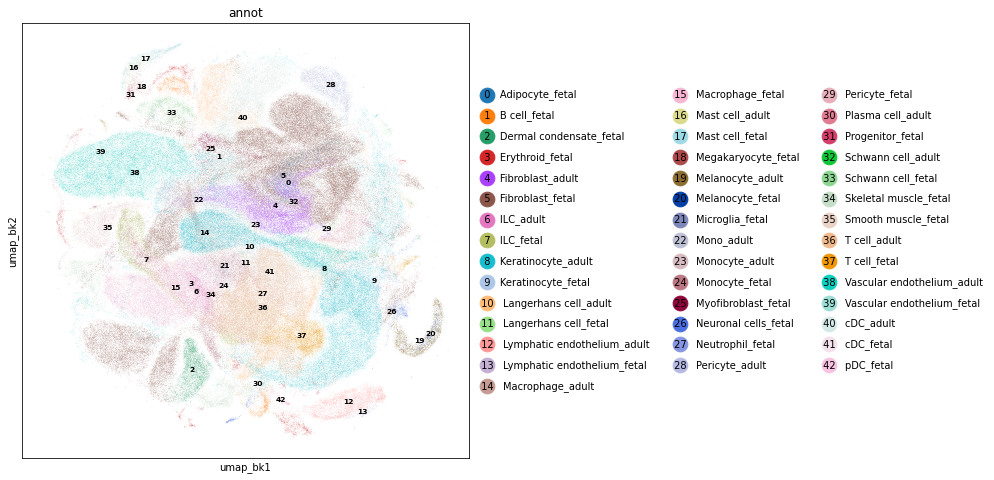

In [54]:
sk.plot_embedding(pooled_ad1a, basis='umap_bk', groupby='annot', figsize=(8, 8));

seems pretty bad, let's do batch correction by batch (donor)

In [55]:
gc.collect()

69615

In [56]:
pooled_ad1b = sk.simple_default_pipeline(
    pooled_ad1,
    post_norm_only=True,
    do_clustering=False,
    use_gpu=False,
    batch='batch',
    batch_method='bbknn',
    hvg_kw={'by_batch': ('batch', 1), 'n_hvg': 2000},
    pca_kw={'remove_genes': ('mito', 'ribo')},
    bk_kw={'metric': 'euclidean'}
)

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'annot' as categorical
... storing 'sample_id' as categorical
... storing 'mad_prd' as categorical
... storing 'Status' as categorical
... storing 'Site' as categorical
... storing 'Site_old' as categorical
... storing 'Tissue' as categ

In [57]:
pooled_ad1b

AnnData object with n_obs × n_vars = 382321 × 20169
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'annot', 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'Sex', 'Age', 'stage', 'anno_final', 'final', 'dataset'
    var: 'gene_ids-fetal', 'gene_ids-SKN8090524-adult', 'mito', 'ribo', 'hb', 'gene_ids', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'hvg_full'
    uns: 'hvg', 'pca', 'neighbo

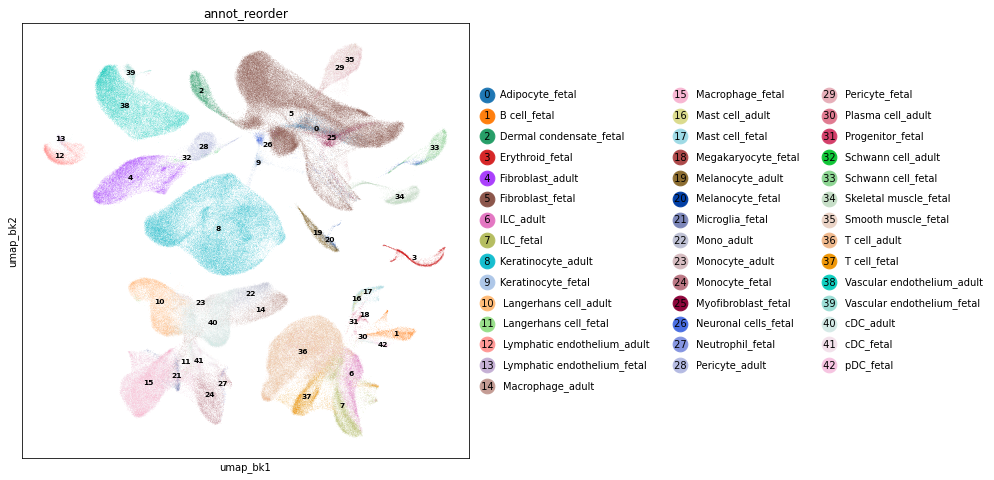

In [59]:
sk.plot_embedding(pooled_ad1b, basis='umap_bk', groupby='annot_reorder', figsize=(8, 8));

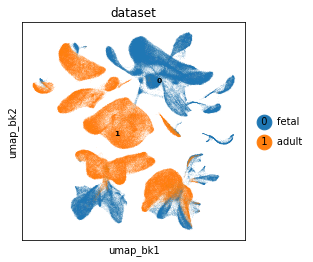

In [60]:
sk.plot_embedding(pooled_ad1b, basis='umap_bk', groupby='dataset', figsize=(4, 4));

better than correcting by dataset, but except for a few cell types, fetal and adult do not mix well

## harmony

correct by both dataset and batch

In [40]:
pooled_ad1c = sk.simple_default_pipeline(
    pooled_ad1,
    post_norm_only=True,
    do_clustering=False,
    use_gpu=False,
    batch=['dataset', 'batch'],
    batch_method='harmony',
    hvg_kw={'by_batch': ('batch', 1), 'n_hvg': 2000},
    pca_kw={'remove_genes': ('mito', 'ribo')},
)

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'sample_id' as categorical
... storing 'mad_prd' as categorical
... storing 'Status' as categorical
... storing 'Site' as categorical
... storing 'Site_old' as categorical
... storing 'Tissue' as categorical
... storing 'Enrichment' as 

2021-10-22 13:29:29,136 - harmonypy - INFO - Iteration 1 of 20
2021-10-22 13:33:55,635 - harmonypy - INFO - Iteration 2 of 20
2021-10-22 13:38:17,479 - harmonypy - INFO - Iteration 3 of 20
2021-10-22 13:42:40,273 - harmonypy - INFO - Converged after 3 iterations


In [41]:
pooled_ad1c

AnnData object with n_obs × n_vars = 382321 × 20169
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'annot', 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'Sex', 'Age', 'stage', 'anno_final', 'final', 'dataset', 'annot_reorder'
    var: 'gene_ids-fetal', 'gene_ids-SKN8090524-adult', 'mito', 'ribo', 'hb', 'gene_ids', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'hvg_full'
    uns: 'hvg'

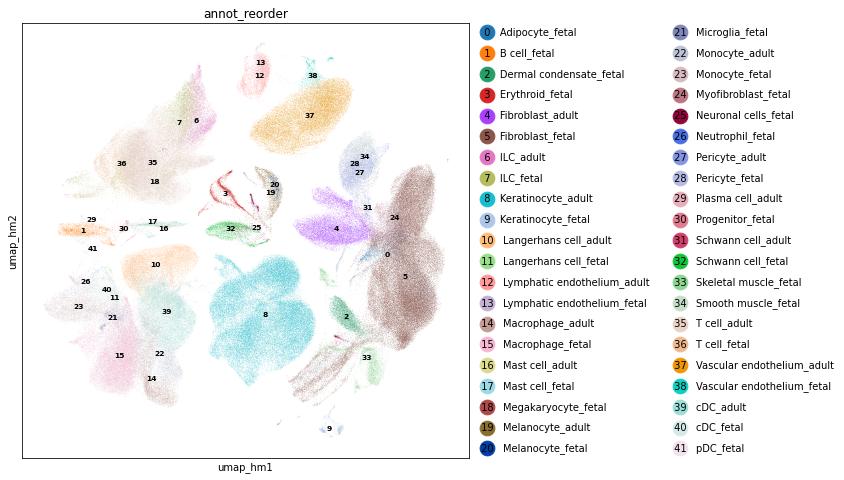

In [42]:
sk.plot_embedding(pooled_ad1c, basis='umap_hm', groupby='annot_reorder', figsize=(8, 8));

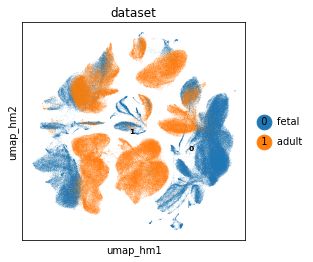

In [43]:
sk.plot_embedding(pooled_ad1c, basis='umap_hm', groupby='dataset', figsize=(4, 4));

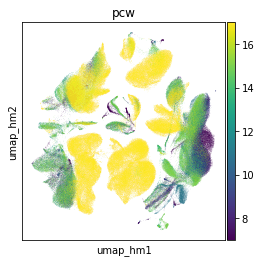

In [45]:
sc.pl.embedding(pooled_ad1c, basis='umap_hm', color='pcw', vmax=17);

better than bbknn (e.g. pericytes mixed, closer between corresponding fetal and adult cell types), but fetal and adult are still largely separated.

save for now.

In [46]:
pooled_ad1c.write('pooled_adult_fetal_skin.inner_join.harmony_processed.h5ad', compression='lzf')

### with down-sampling

In [9]:
pooled_ad1.obs.annot.value_counts()

fetal_Fibroblast               86785
adult_Keratinocyte             53844
adult_T cell                   34774
adult_Vascular endothelium     25785
fetal_Macrophage               22775
adult_Fibroblast               17456
adult_cDC                      15898
adult_Langerhans cell          12545
fetal_ILC                       9522
fetal_T cell                    8078
adult_Macrophage                7205
adult_ILC                       7038
adult_Monocyte                  6685
fetal_Monocyte                  6673
fetal_Pericyte                  6250
fetal_Skeletal muscle           5811
fetal_Dermal condensate         5637
adult_Pericyte                  5006
adult_Lymphatic endothelium     4924
fetal_Schwann cell              3939
adult_Melanocyte                3682
fetal_Erythroid                 3468
fetal_cDC                       3445
fetal_Adipocyte                 3203
fetal_Myofibroblast             3154
fetal_Smooth muscle             3127
fetal_B cell                    3087
f

In [10]:
pooled_ad1S = sk.subsample(pooled_ad1, fraction=0.1, groupby='annot', min_n=200, max_n=5000)

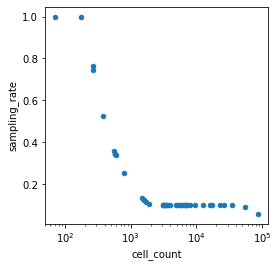

In [65]:
pd.DataFrame(
    {
        'sampling_rate': pooled_ad1S.obs.annot.value_counts().sort_index() / pooled_ad1.obs.annot.value_counts().sort_index(),
        'cell_count': pooled_ad1.obs.annot.value_counts().sort_index(),
    }
).plot.scatter(x='cell_count', y='sampling_rate').set_xscale('log')

In [11]:
pooled_ad1Sc = sk.simple_default_pipeline(
    pooled_ad1S,
    post_norm_only=True,
    do_clustering=False,
    use_gpu=False,
    batch=['dataset', 'batch'],
    batch_method='harmony',
    hvg_kw={'by_batch': ('batch', 1), 'n_hvg': 2000},
    pca_kw={'remove_genes': ('mito', 'ribo')},
)

2021-10-22 17:41:10,587 - harmonypy - INFO - Iteration 1 of 20
2021-10-22 17:41:22,387 - harmonypy - INFO - Iteration 2 of 20
2021-10-22 17:41:33,976 - harmonypy - INFO - Iteration 3 of 20
2021-10-22 17:41:44,705 - harmonypy - INFO - Converged after 3 iterations


In [12]:
pooled_ad1Sc

AnnData object with n_obs × n_vars = 35772 × 18986
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'annot', 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'Sex', 'Age', 'stage', 'anno_final', 'final', 'dataset', 'annot_reorder'
    var: 'gene_ids-fetal', 'gene_ids-SKN8090524-adult', 'mito', 'ribo', 'hb', 'gene_ids', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'hvg_full'
    uns: 'hvg',

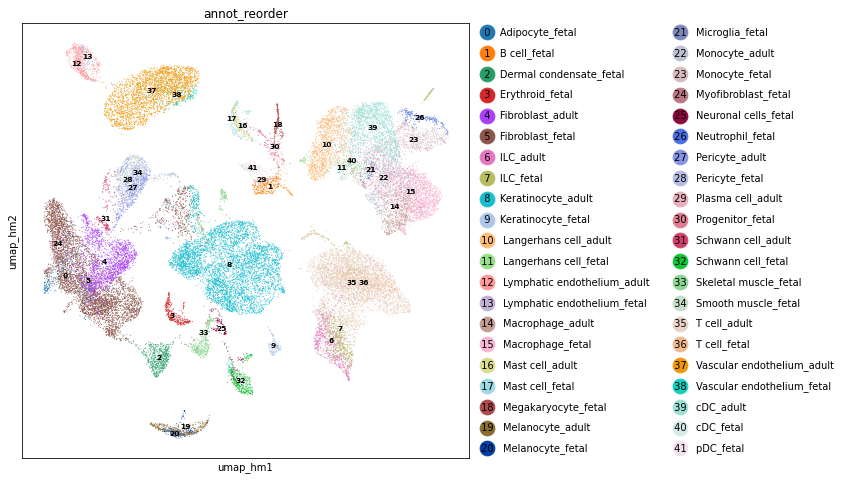

In [13]:
sk.plot_embedding(pooled_ad1Sc, basis='umap_hm', groupby='annot_reorder', figsize=(8, 8));

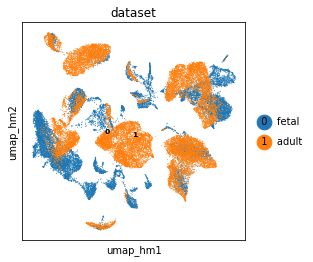

In [14]:
sk.plot_embedding(pooled_ad1Sc, basis='umap_hm', groupby='dataset', figsize=(4, 4));

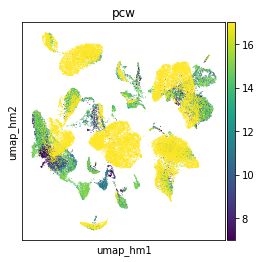

In [15]:
sc.pl.embedding(pooled_ad1Sc, basis='umap_hm', color='pcw', vmax=17);

mixing improved over no-sampling, still some cell types (e.g. KC) are separated

## scvi

In [4]:
import scvi

Global seed set to 0


In [5]:
pooled_ad1.layers['counts'] = pooled_ad1.X.copy()
sc.pp.normalize_total(pooled_ad1, target_sum=1e4)
sc.pp.log1p(pooled_ad1)
pooled_ad1.raw = pooled_ad1

### correct by batch

In [7]:
sc.pp.highly_variable_genes(
    pooled_ad1,
    flavor='seurat_v3',
    n_top_genes=5000,
    layer='counts',
    batch_key='batch',
    subset=True
)

/opt/conda/envs/scrna/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [8]:
scvi.model.SCVI.setup_anndata(pooled_ad1, layer='counts', batch_key='batch')

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 382321 cells, 5000 vars, 20       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [9]:
vae = scvi.model.SCVI(pooled_ad1, n_layers=2, n_latent=30)

In [10]:
vae.train(max_epochs=200, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [1:37:06<00:00, 29.13s/it, loss=1.42e+03, v_num=1]


In [13]:
pooled_ad1.obsm['X_scvi_batch'] = vae.get_latent_representation()

In [14]:
pooled_ad1.write('tmp.h5ad', compression='lzf')

... storing 'is_maternal' as categorical
... storing 'mad_prd' as categorical


In [4]:
pooled_ad1 = sc.read('tmp.h5ad')

In [18]:
joblib.dump(vae, 'tmp_vae.pkl', compress=True)

['tmp_vae.pkl']

In [3]:
vae = joblib.load('tmp_vae.pkl')

In [5]:
sc.pp.neighbors(pooled_ad1, use_rep='X_scvi_batch')
sc.tl.umap(pooled_ad1)

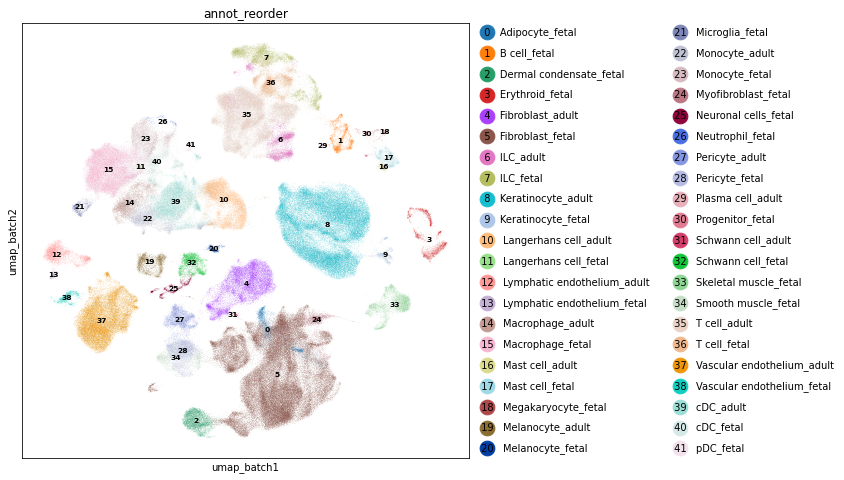

In [15]:
sk.plot_embedding(pooled_ad1, basis='umap_batch', groupby='annot_reorder', figsize=(8,8));

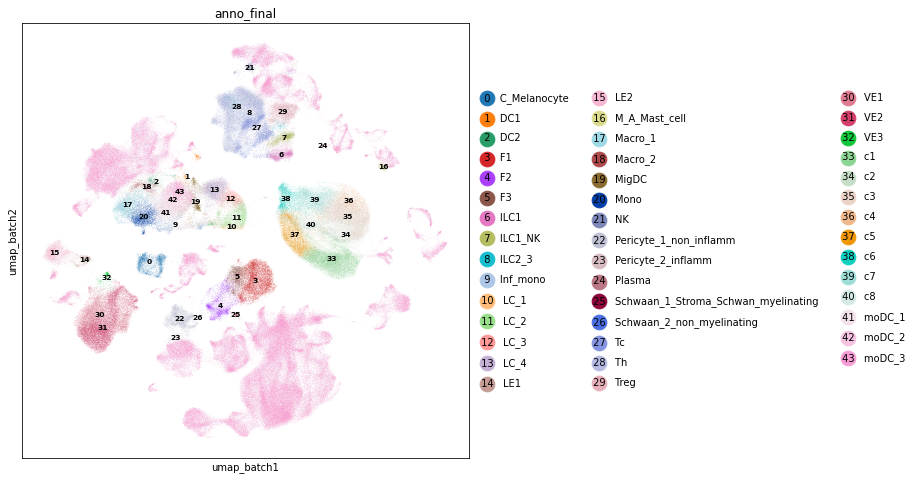

In [21]:
sk.plot_embedding(pooled_ad1, basis='umap_batch', groupby='anno_final', figsize=(8,8));

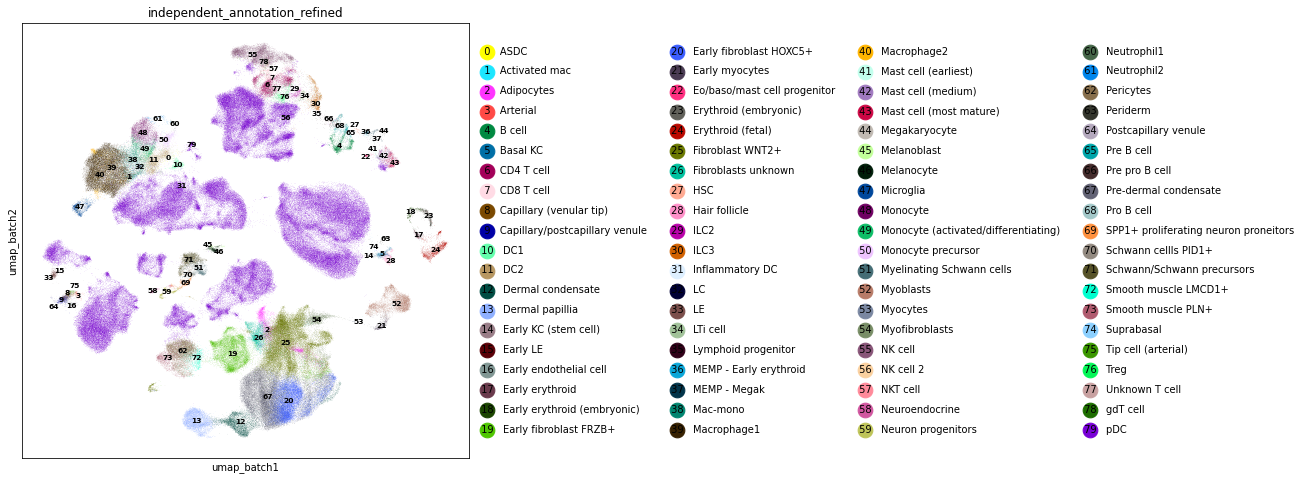

In [22]:
sk.plot_embedding(pooled_ad1, basis='umap_batch', groupby='independent_annotation_refined', figsize=(8,8));

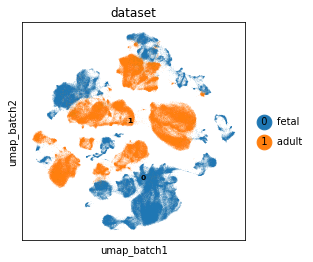

In [16]:
sk.plot_embedding(pooled_ad1, basis='umap_batch', groupby='dataset', figsize=(4, 4));

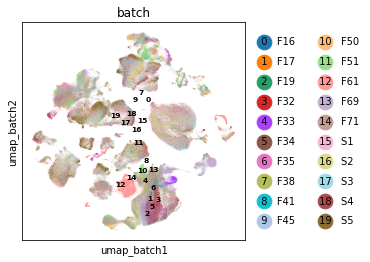

In [28]:
sk.plot_embedding(pooled_ad1, basis='umap_batch', groupby='batch', figsize=(4, 4));

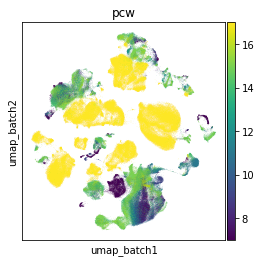

In [20]:
sc.pl.embedding(pooled_ad1, basis='umap_batch', color='pcw', vmax=17);

almost no mixing between fetal and adult dataset

save object

In [29]:
pooled_ad1.write('pooled_adult_fetal_skin.batch_hvg.scvi.h5ad', compression='lzf')

In [19]:
pooled_ad1 = sc.read('pooled_adult_fetal_skin.batch_hvg.scvi.h5ad')

Only considering the two last: ['.scvi', '.h5ad'].
Only considering the two last: ['.scvi', '.h5ad'].


### correct by dataset

In [6]:
sc.pp.highly_variable_genes(
    pooled_ad1,
    flavor='seurat_v3',
    n_top_genes=5000,
    layer='counts',
    batch_key='dataset',
    subset=True
)

/opt/conda/envs/scrna/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [7]:
scvi.model.SCVI.setup_anndata(pooled_ad1, layer='counts', batch_key='dataset')

INFO     Using batches from adata.obs["dataset"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 382321 cells, 5000 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [8]:
vae = scvi.model.SCVI(pooled_ad1, n_layers=2, n_latent=30)

In [9]:
vae.train(max_epochs=200, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [1:35:36<00:00, 28.68s/it, loss=1.3e+03, v_num=1] 


In [10]:
pooled_ad1.obsm['X_scvi_dataset'] = vae.get_latent_representation()

In [11]:
sc.pp.neighbors(pooled_ad1, use_rep='X_scvi_dataset', key_added='neighbors_dataset')
sc.tl.umap(pooled_ad1, neighbors_key='neighbors_dataset')

In [12]:
sk._obj_utils._rename_obsm_key(pooled_ad1, 'X_umap', 'X_umap_dataset')

... storing 'is_maternal' as categorical
... storing 'mad_prd' as categorical


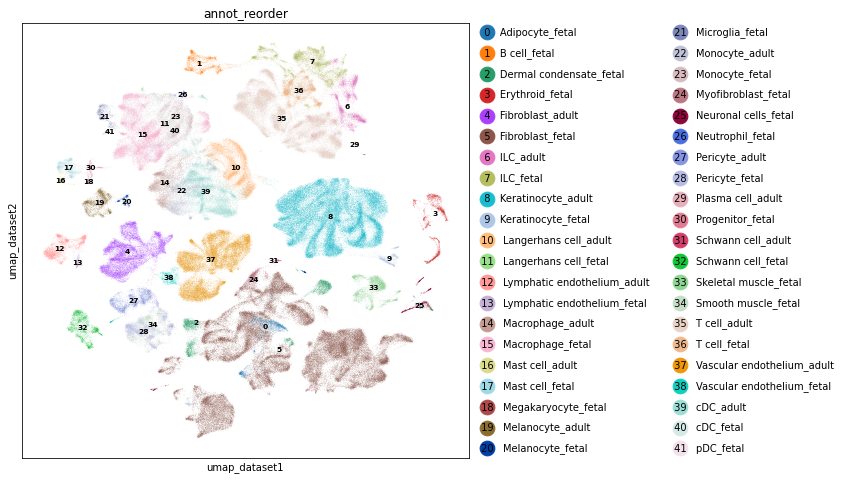

In [13]:
sk.plot_embedding(pooled_ad1, basis='umap_dataset', groupby='annot_reorder', figsize=(8,8));

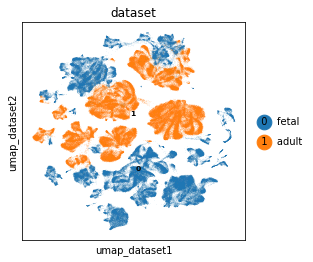

In [14]:
sk.plot_embedding(pooled_ad1, basis='umap_dataset', groupby='dataset', figsize=(4, 4));

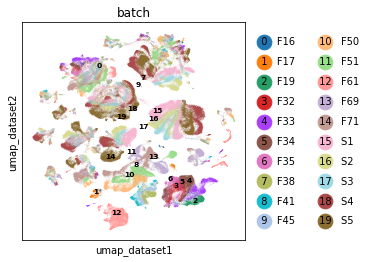

In [15]:
sk.plot_embedding(pooled_ad1, basis='umap_dataset', groupby='batch', figsize=(4, 4));

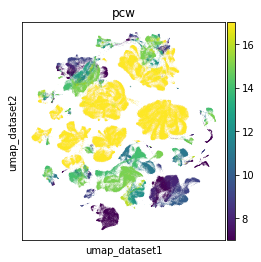

In [16]:
sc.pl.embedding(pooled_ad1, basis='umap_dataset', color='pcw', vmax=17);

neither fetal/adult, nor batches are mixed

save object

In [18]:
pooled_ad1.write('pooled_adult_fetal_skin.dataset_hvg.scvi.h5ad', compression='lzf')